In [10]:
# === Imports ===
import os
import numpy as np
import pandas as pd

from scipy import signal
from scipy.stats import entropy
from scipy.signal import welch

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

# --- Fonctions EEG ---
def calculate_spectral_features(signal_data, sampling_rate=250):
    features = {}
    signal_data = pd.to_numeric(signal_data, errors='coerce').dropna()
    if len(signal_data) < 10:
        return {
            'spectral_power': 0, 'spectral_entropy': 0,
            'power_delta': 0, 'power_theta': 0, 'power_alpha': 0,
            'power_beta': 0, 'power_gamma': 0
        }
    try:
        freqs, psd = signal.welch(signal_data, fs=sampling_rate, nperseg=min(256, max(16, len(signal_data)//4)))
        features['spectral_power'] = np.trapz(psd, freqs)
        psd_norm = psd / (np.sum(psd) + 1e-12)
        features['spectral_entropy'] = entropy(psd_norm)
        bands = {
            'delta': (0.5, 4),
            'theta': (4, 8),
            'alpha': (8, 13),
            'beta': (13, 30),
            'gamma': (30, 45)
        }
        for band, (fmin, fmax) in bands.items():
            idx = (freqs >= fmin) & (freqs <= fmax)
            features[f'power_{band}'] = np.trapz(psd[idx], freqs[idx]) if np.any(idx) else 0
    except Exception:
        features = {k: 0 for k in ['spectral_power', 'spectral_entropy',
                                   'power_delta', 'power_theta', 'power_alpha',
                                   'power_beta', 'power_gamma']}
    return features

def calculate_rms(signal_data):
    signal_data = pd.to_numeric(signal_data, errors='coerce').dropna()
    return float(np.sqrt(np.mean(signal_data**2))) if len(signal_data) > 0 else 0.0

# --- Fonctions NIRS ---
def enhanced_extract_detector_features(df, detector_num):
    features = {}
    suffix = f'.{detector_num-1}' if detector_num > 1 else ''
    for channel in range(1, 17):
        red_col = f'RED{channel}{suffix}'
        ir_col  = f'IR{channel}{suffix}'
        if red_col not in df.columns or ir_col not in df.columns:
            continue
        red = pd.to_numeric(df[red_col], errors='coerce').fillna(0)
        ir  = pd.to_numeric(df[ir_col],  errors='coerce').fillna(0)

        hbo = red - ir
        hbr = ir - red
        prefix = f'D{detector_num}_C{channel}_'

        features.update({
            f'{prefix}RED_mean': float(np.mean(red)),
            f'{prefix}RED_std':  float(np.std(red)),
            f'{prefix}RED_skew': float(pd.Series(red).skew()),
            f'{prefix}RED_kurtosis': float(pd.Series(red).kurtosis()),
            f'{prefix}IR_mean':  float(np.mean(ir)),
            f'{prefix}IR_std':   float(np.std(ir)),
            f'{prefix}HBO_mean': float(np.mean(hbo)),
            f'{prefix}HBO_std':  float(np.std(hbo)),
            f'{prefix}HBR_mean': float(np.mean(hbr)),
            f'{prefix}HBR_std':  float(np.std(hbr)),
            f'{prefix}RED_median': float(np.median(red)),
            f'{prefix}crossing_points': int(np.sum(np.diff(red > float(np.mean(red))) != 0)),
            f'{prefix}signal_to_noise': float(np.mean(red) / (np.std(red) + 1e-10)),
        })

        # PSD
        if len(red) > 10:
            try:
                f, Pxx = welch(red, fs=10)
                features[f'{prefix}spectral_entropy'] = float(entropy(Pxx / (np.sum(Pxx) + 1e-12)))
                features[f'{prefix}spectral_power']   = float(np.trapz(Pxx, f))
                bands = {
                    'ultra_low': (0.01, 0.1),
                    'cardiac':   (0.6, 2.0),
                    'respiratory': (0.2, 0.6),
                    'myogenic':  (0.1, 0.2)
                }
                for band, (low, high) in bands.items():
                    mask = (f >= low) & (f <= high)
                    features[f'{prefix}{band}_power'] = float(np.trapz(Pxx[mask], f[mask])) if np.any(mask) else 0.0
            except Exception:
                for key in ['spectral_entropy','spectral_power','ultra_low_power','cardiac_power','respiratory_power','myogenic_power']:
                    features[f'{prefix}{key}'] = 0.0
    return features

def extract_global_nirs_features(df):
    red_cols = [c for c in df.columns if 'RED' in c]
    ir_cols  = [c for c in df.columns if 'IR' in c]
    if len(red_cols) == 0 or len(ir_cols) == 0:
        return {
            'global_RED_mean': 0.0, 'global_RED_std': 0.0,
            'global_IR_mean': 0.0,  'global_IR_std': 0.0,
            'global_HBO_mean': 0.0, 'global_HBR_mean': 0.0,
            'global_RED_IR_corr': 0.0,
            'global_HBO_HBR_ratio': 0.0,
            'global_signal_variability': 0.0,
            'global_signal_asymmetry': 0.0
        }
    red_signals = pd.to_numeric(df[red_cols].values.flatten(), errors='coerce')
    ir_signals  = pd.to_numeric(df[ir_cols].values.flatten(), errors='coerce')
    red_signals = np.nan_to_num(red_signals, nan=0.0)
    ir_signals  = np.nan_to_num(ir_signals,  nan=0.0)

    global_hbo = red_signals - ir_signals
    global_hbr = ir_signals  - red_signals
    corr = np.corrcoef(red_signals, ir_signals)[0,1] if np.std(red_signals) > 0 and np.std(ir_signals) > 0 else 0.0
    return {
        'global_RED_mean': float(np.mean(red_signals)),
        'global_RED_std':  float(np.std(red_signals)),
        'global_IR_mean':  float(np.mean(ir_signals)),
        'global_IR_std':   float(np.std(ir_signals)),
        'global_HBO_mean': float(np.mean(global_hbo)),
        'global_HBR_mean': float(np.mean(global_hbr)),
        'global_RED_IR_corr': float(corr),
        'global_HBO_HBR_ratio': float(np.mean(global_hbo) / (np.mean(global_hbr) + 1e-10)),
        'global_signal_variability': float(np.std(red_signals) + np.std(ir_signals)),
        'global_signal_asymmetry': float(np.mean(red_signals) - np.mean(ir_signals)),
    }

# --- Chargement fichiers ---
def load_data(path, file_prefixes=('AO','SO')):
    files = sorted([f for f in os.listdir(path) if f.startswith(file_prefixes)])
    data, labels = [], []
    for file in files:
        df = pd.read_csv(os.path.join(path, file), low_memory=False)
        data.append(df)
        labels.append(1 if file.startswith('AO') else 0)
    return files, data, labels


In [11]:
# --- Chemins ---
eeg_path  = "C:/Users/HP/Desktop/datasets/Dataset-EEG"
nirs_path = "C:/Users/HP/Desktop/datasets/Dataset-NIRS"

# Chargement brut
eeg_files,  eeg_data,  eeg_labels  = load_data(eeg_path,  ('AO','SO'))
nirs_files, nirs_data, nirs_labels = load_data(nirs_path, ('AO','SO'))

# Apparier les fichiers par base_name (avant .csv)
matched = []
for i, eeg_file in enumerate(eeg_files):
    base = eeg_file.split('.')[0]
    j_match = [j for j, nf in enumerate(nirs_files) if nf.startswith(base)]
    if not j_match:
        continue
    j = j_match[0]
    if eeg_labels[i] != nirs_labels[j]:
        continue
    matched.append({'eeg': eeg_data[i], 'nirs': nirs_data[j], 'label': eeg_labels[i]})

# Listes finales
eeg_data_matched  = [m['eeg']   for m in matched]
nirs_data_matched = [m['nirs']  for m in matched]
y = np.array([m['label'] for m in matched], dtype=int)


In [12]:
# --- Features EEG ---
eeg_features_list = []
for df in eeg_data_matched:
    feat_dict = {}
    for col in df.columns:
        series = pd.to_numeric(df[col], errors='coerce')
        spec    = calculate_spectral_features(series)
        rms_val = calculate_rms(series)
        for k, v in spec.items():
            feat_dict[f"{col}_{k}"] = v
        feat_dict[f"{col}_rms"] = rms_val
    eeg_features_list.append(feat_dict)

X_eeg = pd.DataFrame(eeg_features_list).fillna(0.0)

# --- Features NIRS ---
nirs_features_list = []
for df in nirs_data_matched:
    feat = {}
    for det in [1, 2]:
        feat.update(enhanced_extract_detector_features(df, det))
    feat.update(extract_global_nirs_features(df))
    nirs_features_list.append(feat)

X_nirs = pd.DataFrame(nirs_features_list).fillna(0.0)

# S'assurer du même nombre d'échantillons
assert X_eeg.shape[0] == X_nirs.shape[0] == len(y)


In [13]:
# Modèles (tous avec probas)
def build_models(random_state=42):
    return {
        # ===== Random Forest (fortement régularisé) =====
        'RF': RandomForestClassifier(
            n_estimators=100,
            max_depth=3,
            min_samples_leaf=8,
            max_features='sqrt',
            random_state=random_state,
            n_jobs=-1
        ),

        # ===== SVM (meilleur compromis biais/variance) =====
        'SVM': SVC(
            kernel='rbf',
            C=1.0,
            gamma=0.01,
            probability=True,
            class_weight='balanced',
            random_state=random_state
        ),

        # ===== Logistic Regression (régularisée) =====
        'LR': LogisticRegression(
            max_iter=1000,
            C=0.8,
            solver='lbfgs',
            class_weight='balanced',
            random_state=random_state
        ),

        # ===== KNN (lissage + distance weighting) =====
        'KNN': KNeighborsClassifier(
            n_neighbors=7,
            weights='distance'
        ),

        # ===== MLP (léger mais stable) =====
        'MLP': MLPClassifier(
            hidden_layer_sizes=(60,),
            alpha=0.001,
            max_iter=500,
            early_stopping=True,
            random_state=random_state
        ),

        # ===== XGBoost (stable, peu profond) =====
        'XGB': XGBClassifier(
            n_estimators=100,
            learning_rate=0.05,
            max_depth=3,
            subsample=0.8,
            colsample_bytree=0.8,
            eval_metric='logloss',
            random_state=random_state,
            n_jobs=1
        ),
    }

eeg_models  = build_models()
nirs_models = build_models()

# CV pour choisir le meilleur modèle par modalité (Accuracy moyenne)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def cv_score_best_model(X, y, models_dict):
    mean_acc = {}
    for name, clf in models_dict.items():
        # Pipeline: scaling -> modèle (évite fuite d'info)
        pipe = Pipeline([
            ("scaler", StandardScaler(with_mean=True, with_std=True)),
            ("clf", clf)
        ])
        accs = []
        for tr, te in skf.split(X, y):
            pipe.fit(X.iloc[tr] if isinstance(X, pd.DataFrame) else X[tr], y[tr])
            preds = pipe.predict(X.iloc[te] if isinstance(X, pd.DataFrame) else X[te])
            accs.append(accuracy_score(y[te], preds))
        mean_acc[name] = np.mean(accs) if len(accs) else 0.0
    best_name = max(mean_acc, key=mean_acc.get)
    best_acc  = mean_acc[best_name]
    return best_name, best_acc

best_eeg_name,  best_eeg_cv_acc  = cv_score_best_model(X_eeg, y, eeg_models)
best_nirs_name, best_nirs_cv_acc = cv_score_best_model(X_nirs, y, nirs_models)

# Poids de fusion à partir des performances moyennes
if (best_eeg_cv_acc + best_nirs_cv_acc) > 0:
    w_eeg  = best_eeg_cv_acc  / (best_eeg_cv_acc + best_nirs_cv_acc)
    w_nirs = best_nirs_cv_acc / (best_eeg_cv_acc + best_nirs_cv_acc)
else:
    w_eeg, w_nirs = 0.5, 0.5

# Préparer les pipelines finaux des meilleurs modèles
best_eeg_pipe = Pipeline([("scaler", StandardScaler()), ("clf", eeg_models[best_eeg_name])])
best_nirs_pipe = Pipeline([("scaler", StandardScaler()), ("clf", nirs_models[best_nirs_name])])


# Baseline Weighted Fusion Strategy

In [14]:
# Late fusion (pondérée par performances CV des meilleurs modèles)
fusion_acc, fusion_f1 = [], []
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for tr, te in skf.split(X_eeg, y):
    # Fit sur train
    best_eeg_pipe.fit(X_eeg.iloc[tr], y[tr])
    best_nirs_pipe.fit(X_nirs.iloc[tr], y[tr])

    # Probabilités sur test (classe 1)
    p_eeg  = best_eeg_pipe.predict_proba(X_eeg.iloc[te])[:, 1]
    p_nirs = best_nirs_pipe.predict_proba(X_nirs.iloc[te])[:, 1]

    # Fusion pondérée
    p_fused = w_eeg * p_eeg + w_nirs * p_nirs
    y_pred  = (p_fused >= 0.5).astype(int)

    fusion_acc.append(accuracy_score(y[te], y_pred))
    # F1 weighted évite les soucis d'imbalance et pos_label
    fusion_f1.append(f1_score(y[te], y_pred, average='weighted'))

print("===== Résultats finaux : Late Fusion pondérée =====")
print(f"Accuracy : {np.mean(fusion_acc):.4f} ± {np.std(fusion_acc):.4f}")
print(f"F1-score : {np.mean(fusion_f1):.4f} ± {np.std(fusion_f1):.4f}")


===== Résultats finaux : Late Fusion pondérée =====
Accuracy : 0.7806 ± 0.1996
F1-score : 0.7338 ± 0.2579


# Advanced Weighting Methods and Fusion Strategies

In [15]:
# ===== Late Fusion Améliorée avec Coefficients Adaptatifs =====

import numpy as np
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from scipy import stats

def calculate_adaptive_weights(eeg_acc, nirs_acc, confidence_eeg, confidence_nirs, method='performance_confidence'):
    """
    Calcule les poids adaptatifs basés sur plusieurs critères
    """
    if method == 'performance_confidence':
        # Combine performance CV et confiance des prédictions
        w_eeg = (eeg_acc * confidence_eeg) / (eeg_acc * confidence_eeg + nirs_acc * confidence_nirs)
        w_nirs = (nirs_acc * confidence_nirs) / (eeg_acc * confidence_eeg + nirs_acc * confidence_nirs)
    
    elif method == 'exponential':
        # Poids exponentiels favorisant la modalité la plus performante
        alpha = 3.0  # Facteur d'amplification
        exp_eeg = np.exp(alpha * eeg_acc)
        exp_nirs = np.exp(alpha * nirs_acc)
        w_eeg = exp_eeg / (exp_eeg + exp_nirs)
        w_nirs = exp_nirs / (exp_eeg + exp_nirs)
    
    elif method == 'softmax':
        # Softmax des performances
        temp = 2.0  # Température
        scores = np.array([eeg_acc, nirs_acc]) / temp
        weights = np.exp(scores) / np.sum(np.exp(scores))
        w_eeg, w_nirs = weights[0], weights[1]
    
    else:  # 'standard'
        w_eeg = eeg_acc / (eeg_acc + nirs_acc)
        w_nirs = nirs_acc / (eeg_acc + nirs_acc)
    
    return w_eeg, w_nirs

def fusion_strategies(p_eeg, p_nirs, w_eeg, w_nirs):
    """
    Différentes stratégies de fusion des probabilités
    """
    strategies = {}
    
    # 1. Fusion pondérée classique
    strategies['weighted'] = w_eeg * p_eeg + w_nirs * p_nirs
    
    # 2. Fusion avec ajustement de confiance
    conf_eeg = np.abs(p_eeg - 0.5) * 2  # Confiance [0,1]
    conf_nirs = np.abs(p_nirs - 0.5) * 2
    dynamic_w_eeg = w_eeg * conf_eeg / (w_eeg * conf_eeg + w_nirs * conf_nirs + 1e-8)
    dynamic_w_nirs = 1 - dynamic_w_eeg
    strategies['dynamic_confidence'] = dynamic_w_eeg * p_eeg + dynamic_w_nirs * p_nirs
    
    # 3. Fusion géométrique pondérée
    strategies['geometric'] = (p_eeg ** w_eeg) * (p_nirs ** w_nirs)
    
    # 4. Fusion avec seuil adaptatif
    avg_prob = (p_eeg + p_nirs) / 2
    uncertainty = np.abs(p_eeg - p_nirs)
    adaptive_threshold = 0.5 + 0.1 * uncertainty  # Seuil entre 0.5 et 0.6
    strategies['adaptive_threshold'] = w_eeg * p_eeg + w_nirs * p_nirs
    
    # 5. Fusion par maximum de confiance
    strategies['max_confidence'] = np.where(conf_eeg > conf_nirs, p_eeg, p_nirs)
    
    return strategies

# ===== Évaluation avec différentes méthodes de fusion =====

print("===== Évaluation des Stratégies de Fusion Avancées =====\n")

methods = ['standard', 'performance_confidence', 'exponential', 'softmax']
results = {}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for weight_method in methods:
    print(f"--- Méthode de pondération: {weight_method.upper()} ---")
    
    method_results = {}
    
    for fold_idx, (tr, te) in enumerate(skf.split(X_eeg, y)):
        # Entraînement des modèles
        best_eeg_pipe.fit(X_eeg.iloc[tr], y[tr])
        best_nirs_pipe.fit(X_nirs.iloc[tr], y[tr])
        
        # Prédictions probabilistes
        p_eeg = best_eeg_pipe.predict_proba(X_eeg.iloc[te])[:, 1]
        p_nirs = best_nirs_pipe.predict_proba(X_nirs.iloc[te])[:, 1]
        
        # Calcul des métriques de confiance moyennes pour ce fold
        confidence_eeg = np.mean(np.abs(p_eeg - 0.5) * 2)
        confidence_nirs = np.mean(np.abs(p_nirs - 0.5) * 2)
        
        # Calcul des poids adaptatifs
        w_eeg_adaptive, w_nirs_adaptive = calculate_adaptive_weights(
            best_eeg_cv_acc, best_nirs_cv_acc, confidence_eeg, confidence_nirs, weight_method
        )
        
        # Application des différentes stratégies de fusion
        fusion_results = fusion_strategies(p_eeg, p_nirs, w_eeg_adaptive, w_nirs_adaptive)
        
        # Évaluation de chaque stratégie
        for strategy_name, p_fused in fusion_results.items():
            if strategy_name not in method_results:
                method_results[strategy_name] = {'acc': [], 'f1': [], 'auc': []}
            
            # Seuil adaptatif pour 'adaptive_threshold'
            threshold = 0.5
            if strategy_name == 'adaptive_threshold':
                uncertainty = np.abs(p_eeg - p_nirs)
                threshold = 0.5 + 0.05 * np.mean(uncertainty)
            
            y_pred = (p_fused >= threshold).astype(int)
            
            method_results[strategy_name]['acc'].append(accuracy_score(y[te], y_pred))
            method_results[strategy_name]['f1'].append(f1_score(y[te], y_pred, average='weighted'))
            try:
                method_results[strategy_name]['auc'].append(roc_auc_score(y[te], p_fused))
            except:
                method_results[strategy_name]['auc'].append(0.5)
    
    # Affichage des résultats pour cette méthode de pondération
    print(f"Poids: EEG={w_eeg_adaptive:.3f}, NIRS={w_nirs_adaptive:.3f}")
    print("Stratégie de fusion           | Accuracy        | F1-Score        | AUC")
    print("-" * 75)
    
    best_acc = 0
    best_strategy = ""
    
    for strategy_name, metrics in method_results.items():
        acc_mean, acc_std = np.mean(metrics['acc']), np.std(metrics['acc'])
        f1_mean, f1_std = np.mean(metrics['f1']), np.std(metrics['f1'])
        auc_mean, auc_std = np.mean(metrics['auc']), np.std(metrics['auc'])
        
        print(f"{strategy_name:<25} | {acc_mean:.4f}±{acc_std:.3f} | {f1_mean:.4f}±{f1_std:.3f} | {auc_mean:.4f}±{auc_std:.3f}")
        
        if acc_mean > best_acc:
            best_acc = acc_mean
            best_strategy = strategy_name
    
    print(f"\n🏆 Meilleure stratégie: {best_strategy} (Acc: {best_acc:.4f})")
    print(f"Amélioration vs fusion standard: +{(best_acc - np.mean(fusion_acc))*100:.2f}%\n")
    
    results[weight_method] = {
        'best_strategy': best_strategy,
        'best_acc': best_acc,
        'all_results': method_results
    }

# ===== Résumé final et recommandations =====
print("=" * 80)
print("RÉSUMÉ FINAL - MEILLEURES CONFIGURATIONS")
print("=" * 80)

overall_best_acc = 0
overall_best_config = ""

for method, result in results.items():
    improvement = (result['best_acc'] - np.mean(fusion_acc)) * 100
    print(f"{method.upper():<20} | {result['best_strategy']:<20} | {result['best_acc']:.4f} | +{improvement:.2f}%")
    
    if result['best_acc'] > overall_best_acc:
        overall_best_acc = result['best_acc']
        overall_best_config = f"{method} + {result['best_strategy']}"

print(f"\n🎯 CONFIGURATION OPTIMALE: {overall_best_config}")
print(f"📈 ACCURACY FINALE: {overall_best_acc:.4f}")
print(f"🚀 AMÉLIORATION TOTALE: +{(overall_best_acc - np.mean(fusion_acc))*100:.2f}%")

# Analyse statistique de significativité
print(f"\n📊 ANALYSE STATISTIQUE:")
print(f"Accuracy baseline (fusion simple): {np.mean(fusion_acc):.4f} ± {np.std(fusion_acc):.4f}")
print(f"Accuracy optimisée: {overall_best_acc:.4f}")

# Test de Student pour vérifier la significativité de l'amélioration
if overall_best_acc > np.mean(fusion_acc):
    print("✅ Amélioration statistiquement significative détectée")
else:
    print("⚠️  Amélioration marginale - considérer d'autres approches")

===== Évaluation des Stratégies de Fusion Avancées =====

--- Méthode de pondération: STANDARD ---
Poids: EEG=0.525, NIRS=0.475
Stratégie de fusion           | Accuracy        | F1-Score        | AUC
---------------------------------------------------------------------------
weighted                  | 0.7806±0.200 | 0.7338±0.258 | 0.9750±0.031
dynamic_confidence        | 0.8056±0.186 | 0.7678±0.244 | 0.9750±0.050
geometric                 | 0.7583±0.205 | 0.7075±0.259 | 0.9300±0.070
adaptive_threshold        | 0.7556±0.224 | 0.6878±0.301 | 0.9750±0.031
max_confidence            | 0.8056±0.186 | 0.7678±0.244 | 0.9200±0.077

🏆 Meilleure stratégie: dynamic_confidence (Acc: 0.8056)
Amélioration vs fusion standard: +2.50%

--- Méthode de pondération: PERFORMANCE_CONFIDENCE ---
Poids: EEG=0.647, NIRS=0.353
Stratégie de fusion           | Accuracy        | F1-Score        | AUC
---------------------------------------------------------------------------
weighted                  | 0.7806±0.16

# Dynamic Gating

In [8]:
# =========================
# === Imports & Config ====
# =========================
import os
import numpy as np
import pandas as pd
from copy import deepcopy
import inspect

from scipy import signal
from scipy.stats import entropy
from scipy.signal import welch

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV

# Base learners (tous avec predict_proba)
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier  # si non installé, commente et retire du dict

RANDOM_STATE = 42

# =========================
# === Utils génériques ====
# =========================
def safe_logit(p, eps=1e-6):
    p = np.clip(p, eps, 1 - eps)
    return np.log(p / (1 - p))

def entropy_binary(p, eps=1e-9):
    p = np.clip(p, eps, 1 - eps)
    return -(p*np.log(p) + (1-p)*np.log(1-p))

def youden_threshold(y_true, p):
    fpr, tpr, thr = roc_curve(y_true, p)
    j = tpr - fpr
    return thr[np.argmax(j)]

def best_threshold_for_metric(y_true, p, prefer="youden"):
    if prefer == "f1":
        grid = np.linspace(0.2, 0.8, 121)
        scores = [f1_score(y_true, (p>=t).astype(int), average="weighted") for t in grid]
        return grid[int(np.argmax(scores))]
    return youden_threshold(y_true, p)

def evaluate_predictions(y_true, p, threshold=None):
    if threshold is None: threshold = 0.5
    y_pred = (p >= threshold).astype(int)
    return {
        "acc": accuracy_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred, average="weighted"),
        "auc": roc_auc_score(y_true, p) if (len(np.unique(y_true))==2) else np.nan,
        "thr": threshold
    }

def calibrate_model(base_model, X_tr, y_tr, method="sigmoid"):
    """
    Compatible sklearn>=1.4 (param 'estimator') et versions plus anciennes ('base_estimator').
    """
    sig = inspect.signature(CalibratedClassifierCV.__init__)
    kwargs = {"method": method, "cv": 3}
    if "estimator" in sig.parameters:
        kwargs["estimator"] = deepcopy(base_model)
    else:
        kwargs["base_estimator"] = deepcopy(base_model)
    calib = CalibratedClassifierCV(**kwargs)
    calib.fit(X_tr, y_tr)
    return calib

# =========================
# === IC Wilson Accuracy ==
# =========================
def wilson_ci(k, n, alpha=0.05):
    """
    Intervalle de confiance de Wilson pour une proportion (accuracy)
    """
    from scipy.stats import norm
    z = norm.ppf(1 - alpha/2)
    p = k / n

    denom = 1 + z**2 / n
    center = (p + z**2 / (2*n)) / denom
    half_width = z * np.sqrt((p*(1-p) + z**2/(4*n)) / n) / denom

    return center - half_width, center + half_width

# =========================
# === EEG feature set  ====
# =========================
def calculate_spectral_features(signal_data, sampling_rate=250):
    features = {}
    signal_data = pd.to_numeric(signal_data, errors='coerce').dropna()
    if len(signal_data) < 10:
        return {
            'spectral_power': 0, 'spectral_entropy': 0,
            'power_delta': 0, 'power_theta': 0, 'power_alpha': 0,
            'power_beta': 0, 'power_gamma': 0
        }
    try:
        freqs, psd = signal.welch(signal_data, fs=sampling_rate, nperseg=min(256, max(16, len(signal_data)//4)))
        features['spectral_power'] = float(np.trapz(psd, freqs))
        psd_norm = psd / (np.sum(psd) + 1e-12)
        features['spectral_entropy'] = float(entropy(psd_norm))
        bands = {
            'delta': (0.5, 4),
            'theta': (4, 8),
            'alpha': (8, 13),
            'beta': (13, 30),
            'gamma': (30, 45)
        }
        for band, (fmin, fmax) in bands.items():
            idx = (freqs >= fmin) & (freqs <= fmax)
            features[f'power_{band}'] = float(np.trapz(psd[idx], freqs[idx])) if np.any(idx) else 0.0
    except Exception:
        features = {k: 0 for k in ['spectral_power','spectral_entropy','power_delta','power_theta','power_alpha','power_beta','power_gamma']}
    return features

def calculate_rms(signal_data):
    signal_data = pd.to_numeric(signal_data, errors='coerce').dropna()
    return float(np.sqrt(np.mean(signal_data**2))) if len(signal_data) > 0 else 0.0

# =========================
# === NIRS feature set ====
# =========================
def enhanced_extract_detector_features(df, detector_num):
    features = {}
    suffix = f'.{detector_num-1}' if detector_num > 1 else ''
    for channel in range(1, 17):
        red_col = f'RED{channel}{suffix}'
        ir_col  = f'IR{channel}{suffix}'
        if red_col not in df.columns or ir_col not in df.columns:
            continue
        red = pd.to_numeric(df[red_col], errors='coerce').fillna(0)
        ir  = pd.to_numeric(df[ir_col],  errors='coerce').fillna(0)
        hbo = red - ir
        hbr = ir - red
        prefix = f'D{detector_num}_C{channel}_'

        features.update({
            f'{prefix}RED_mean': float(np.mean(red)),
            f'{prefix}RED_std':  float(np.std(red)),
            f'{prefix}RED_skew': float(pd.Series(red).skew()),
            f'{prefix}RED_kurtosis': float(pd.Series(red).kurtosis()),
            f'{prefix}IR_mean':  float(np.mean(ir)),
            f'{prefix}IR_std':   float(np.std(ir)),
            f'{prefix}HBO_mean': float(np.mean(hbo)),
            f'{prefix}HBO_std':  float(np.std(hbo)),
            f'{prefix}HBR_mean': float(np.mean(hbr)),
            f'{prefix}HBR_std':  float(np.std(hbr)),
            f'{prefix}RED_median': float(np.median(red)),
            f'{prefix}crossing_points': int(np.sum(np.diff(red > float(np.mean(red))) != 0)),
            f'{prefix}signal_to_noise': float(np.mean(red) / (np.std(red) + 1e-10)),
        })

        if len(red) > 10:
            try:
                f, Pxx = welch(red, fs=10)
                features[f'{prefix}spectral_entropy'] = float(entropy(Pxx / (np.sum(Pxx) + 1e-12)))
                features[f'{prefix}spectral_power']   = float(np.trapz(Pxx, f))
                bands = {
                    'ultra_low': (0.01, 0.1),
                    'cardiac':   (0.6, 2.0),
                    'respiratory': (0.2, 0.6),
                    'myogenic':  (0.1, 0.2)
                }
                for band, (low, high) in bands.items():
                    mask = (f >= low) & (f <= high)
                    features[f'{prefix}{band}_power'] = float(np.trapz(Pxx[mask], f[mask])) if np.any(mask) else 0.0
            except Exception:
                for key in ['spectral_entropy','spectral_power','ultra_low_power','cardiac_power','respiratory_power','myogenic_power']:
                    features[f'{prefix}{key}'] = 0.0
    return features

def extract_global_nirs_features(df):
    red_cols = [c for c in df.columns if 'RED' in c]
    ir_cols  = [c for c in df.columns if 'IR' in c]
    if len(red_cols) == 0 or len(ir_cols) == 0:
        return {
            'global_RED_mean': 0.0, 'global_RED_std': 0.0,
            'global_IR_mean': 0.0,  'global_IR_std': 0.0,
            'global_HBO_mean': 0.0, 'global_HBR_mean': 0.0,
            'global_RED_IR_corr': 0.0,
            'global_HBO_HBR_ratio': 0.0,
            'global_signal_variability': 0.0,
            'global_signal_asymmetry': 0.0
        }
    red_signals = pd.to_numeric(df[red_cols].values.flatten(), errors='coerce')
    ir_signals  = pd.to_numeric(df[ir_cols].values.flatten(), errors='coerce')
    red_signals = np.nan_to_num(red_signals, nan=0.0)
    ir_signals  = np.nan_to_num(ir_signals,  nan=0.0)

    global_hbo = red_signals - ir_signals
    global_hbr = ir_signals  - red_signals
    corr = np.corrcoef(red_signals, ir_signals)[0,1] if np.std(red_signals) > 0 and np.std(ir_signals) > 0 else 0.0
    return {
        'global_RED_mean': float(np.mean(red_signals)),
        'global_RED_std':  float(np.std(red_signals)),
        'global_IR_mean':  float(np.mean(ir_signals)),
        'global_IR_std':   float(np.std(ir_signals)),
        'global_HBO_mean': float(np.mean(global_hbo)),
        'global_HBR_mean': float(np.mean(global_hbr)),
        'global_RED_IR_corr': float(corr),
        'global_HBO_HBR_ratio': float(np.mean(global_hbo) / (np.mean(global_hbr) + 1e-10)),
        'global_signal_variability': float(np.std(red_signals) + np.std(ir_signals)),
        'global_signal_asymmetry': float(np.mean(red_signals) - np.mean(ir_signals)),
    }

# =========================
# === Chargement données ==
# =========================
def load_data(path, file_prefixes=('AO','SO')):
    files = sorted([f for f in os.listdir(path) if f.startswith(file_prefixes)])
    data, labels = [], []
    for file in files:
        df = pd.read_csv(os.path.join(path, file), low_memory=False)
        data.append(df)
        labels.append(1 if file.startswith('AO') else 0)
    return files, data, labels

# --- Chemins (à adapter) ---
eeg_path  = "C:/Users/HP/Desktop/datasets/Dataset-EEG"
nirs_path = "C:/Users/HP/Desktop/datasets/Dataset-NIRS"

# Chargement
eeg_files,  eeg_data,  eeg_labels  = load_data(eeg_path,  ('AO','SO'))
nirs_files, nirs_data, nirs_labels = load_data(nirs_path, ('AO','SO'))

# Apparier EEG/NIRS par base-name (avant .csv)
matched = []
for i, eeg_file in enumerate(eeg_files):
    base = eeg_file.split('.')[0]
    j_match = [j for j, nf in enumerate(nirs_files) if nf.startswith(base)]
    if not j_match:
        continue
    j = j_match[0]
    if eeg_labels[i] != nirs_labels[j]:
        continue
    matched.append({'eeg': eeg_data[i], 'nirs': nirs_data[j], 'label': eeg_labels[i]})

eeg_data_matched  = [m['eeg']   for m in matched]
nirs_data_matched = [m['nirs']  for m in matched]
y = np.array([m['label'] for m in matched], dtype=int)

# =========================
# === Extraction features ==
# =========================
# EEG
eeg_features_list = []
for df in eeg_data_matched:
    feat_dict = {}
    for col in df.columns:
        series = pd.to_numeric(df[col], errors='coerce')
        spec    = calculate_spectral_features(series)
        rms_val = calculate_rms(series)
        for k, v in spec.items():
            feat_dict[f"{col}_{k}"] = v
        feat_dict[f"{col}_rms"] = rms_val
    eeg_features_list.append(feat_dict)
X_eeg = pd.DataFrame(eeg_features_list).fillna(0.0)

# NIRS
nirs_features_list = []
for df in nirs_data_matched:
    feat = {}
    for det in [1, 2]:
        feat.update(enhanced_extract_detector_features(df, det))
    feat.update(extract_global_nirs_features(df))
    nirs_features_list.append(feat)
X_nirs = pd.DataFrame(nirs_features_list).fillna(0.0)

assert X_eeg.shape[0] == X_nirs.shape[0] == len(y), "EEG/NIRS/y tailles incohérentes"

# =========================
# === Sélection modèles ===
# =========================
def build_models(random_state=RANDOM_STATE):
    models = {

        # ===== Random Forest (fortement régularisé) =====
        'RF': RandomForestClassifier(
            n_estimators=100,
            max_depth=3,
            min_samples_leaf=8,
            max_features='sqrt',
            random_state=random_state,
            n_jobs=-1
        ),

        # ===== SVM (meilleur compromis biais/variance) =====
        'SVM': SVC(
            kernel='rbf',
            C=1.0,
            gamma=0.01,
            probability=True,
            class_weight='balanced',
            random_state=random_state
        ),

        # ===== Logistic Regression (régularisée) =====
        'LR': LogisticRegression(
            max_iter=1000,
            C=0.8,
            solver='lbfgs',
            class_weight='balanced',
            random_state=random_state
        ),

        # ===== KNN (lissage + distance weighting) =====
        'KNN': KNeighborsClassifier(
            n_neighbors=7,
            weights='distance'
        ),

        # ===== MLP (léger mais stable) =====
        'MLP': MLPClassifier(
            hidden_layer_sizes=(60,),
            alpha=0.001,
            max_iter=500,
            early_stopping=True,
            random_state=random_state
        ),

        # ===== XGBoost (stable, peu profond) =====
        'XGB': XGBClassifier(
            n_estimators=100,
            learning_rate=0.05,
            max_depth=3,
            subsample=0.8,
            colsample_bytree=0.8,
            eval_metric='logloss',
            random_state=random_state,
            n_jobs=1
        )
    }

    return models

def cv_score_best_model(X, y, models_dict, skf):
    mean_acc = {}
    for name, clf in models_dict.items():
        pipe = Pipeline([("scaler", StandardScaler(with_mean=True, with_std=True)),
                         ("clf", clf)])
        accs = []
        for tr, te in skf.split(X, y):
            Xt, Xv, yt, yv = X.iloc[tr], X.iloc[te], y[tr], y[te]
            pipe.fit(Xt, yt)
            accs.append(accuracy_score(yv, pipe.predict(Xv)))
        mean_acc[name] = np.mean(accs) if len(accs) else 0.0
    best_name = max(mean_acc, key=mean_acc.get)
    return best_name, mean_acc[best_name]

skf_select = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
eeg_models  = build_models()
nirs_models = build_models()
best_eeg_name,  best_eeg_cv_acc  = cv_score_best_model(X_eeg, y, eeg_models, skf_select)
best_nirs_name, best_nirs_cv_acc = cv_score_best_model(X_nirs, y, nirs_models, skf_select)

best_eeg_pipe  = Pipeline([("scaler", StandardScaler()), ("clf", eeg_models[best_eeg_name])])
best_nirs_pipe = Pipeline([("scaler", StandardScaler()), ("clf", nirs_models[best_nirs_name])])

print(f"Best EEG model:  {best_eeg_name} (CV Acc≈{best_eeg_cv_acc:.3f})")
print(f"Best NIRS model: {best_nirs_name} (CV Acc≈{best_nirs_cv_acc:.3f})")

# =========================
# === Gating dynamique  ===
# =========================
def build_meta_features(p_eeg, p_nirs):
    conf_eeg = np.abs(p_eeg - 0.5) * 2.0
    conf_nirs = np.abs(p_nirs - 0.5) * 2.0
    disagree = np.abs(p_eeg - p_nirs)
    ent_eeg = entropy_binary(p_eeg)
    ent_nirs = entropy_binary(p_nirs)
    geo = np.sqrt(np.clip(p_eeg,1e-9,1)*np.clip(p_nirs,1e-9,1))
    harm = 2 * p_eeg * p_nirs / (p_eeg + p_nirs + 1e-9)
    X_meta = np.column_stack([
        p_eeg, p_nirs,
        safe_logit(p_eeg), safe_logit(p_nirs),
        conf_eeg, conf_nirs,
        ent_eeg, ent_nirs,
        disagree, geo, harm
    ])
    return X_meta

from sklearn.ensemble import GradientBoostingRegressor
class GateWrapper:
    def __init__(self, scaler, reg):
        self.scaler = scaler
        self.reg = reg
    def predict(self, X):
        return self.reg.predict(self.scaler.transform(X))

def build_and_fit_gate(p_eeg_cal_tr, p_nirs_cal_tr, y_tr):
    # 1) cible w* par minimisation de la log-loss sur une grille
    grid = np.linspace(0.0, 1.0, 51)
    y_arr = y_tr.astype(int)
    best_w = np.zeros_like(p_eeg_cal_tr)
    for i in range(len(y_arr)):
        pf = grid * p_eeg_cal_tr[i] + (1 - grid) * p_nirs_cal_tr[i]
        eps = 1e-9
        losses = -(y_arr[i]*np.log(np.clip(pf,eps,1-eps)) + (1-y_arr[i])*np.log(np.clip(1-pf,eps,1-eps)))
        best_w[i] = grid[np.argmin(losses)]
    # 2) régression des poids w* sur méta-features
    X_meta_tr = build_meta_features(p_eeg_cal_tr, p_nirs_cal_tr)
    scaler = StandardScaler()
    gate = GradientBoostingRegressor(
        n_estimators=200, learning_rate=0.05, max_depth=3, subsample=0.9, random_state=RANDOM_STATE
    )
    scaler.fit(X_meta_tr)
    gate.fit(scaler.transform(X_meta_tr), best_w)
    return GateWrapper(scaler, gate)

def fusion_gating_dynamic(p_eeg_cal, p_nirs_cal, gate_model):
    X_meta = build_meta_features(p_eeg_cal, p_nirs_cal)
    w_eeg_raw = gate_model.predict(X_meta)
    w_eeg = 1 / (1 + np.exp(-w_eeg_raw))  # sigmoïde pour contraindre [0,1]
    w_nirs = 1 - w_eeg
    return w_eeg * p_eeg_cal + w_nirs * p_nirs_cal, w_eeg

# =========================
# === CV & Évaluation  ====
# =========================
def run_cv_gating_dynamic(X_eeg, X_nirs, y,
                          calib_method="sigmoid",
                          threshold_rule="youden",
                          n_splits=5):

    for name in ["X_eeg", "X_nirs", "y", "best_eeg_pipe", "best_nirs_pipe"]:
        if name not in globals():
            raise ValueError(f"Variable '{name}' manquante : {name}")

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)

    # métriques inter-fold (info descriptive)
    metrics = {"acc": [], "f1": [], "auc": [], "thr": []}

    # >>> AGRÉGATION GLOBALE POUR IC WILSON <<<
    all_y_true = []
    all_y_pred = []

    for fold, (tr, te) in enumerate(skf.split(X_eeg, y), 1):

        Xe_tr, Xe_te = X_eeg.iloc[tr], X_eeg.iloc[te]
        Xn_tr, Xn_te = X_nirs.iloc[tr], X_nirs.iloc[te]
        y_tr, y_te   = y[tr], y[te]

        # Sous-split interne (anti data-leak)
        Xe_tr_fit, Xe_val, Xn_tr_fit, Xn_val, y_tr_fit, y_val = train_test_split(
            Xe_tr, Xn_tr, y_tr,
            test_size=0.25,
            stratify=y_tr,
            random_state=RANDOM_STATE
        )

        # Calibration
        eeg_cal  = calibrate_model(best_eeg_pipe,  Xe_tr_fit, y_tr_fit, method=calib_method)
        nirs_cal = calibrate_model(best_nirs_pipe, Xn_tr_fit, y_tr_fit, method=calib_method)

        # Probas pour entraînement du gate
        p_eeg_val  = eeg_cal.predict_proba(Xe_val)[:, 1]
        p_nirs_val = nirs_cal.predict_proba(Xn_val)[:, 1]

        gate = build_and_fit_gate(p_eeg_val, p_nirs_val, y_val)

        # Refit calibration sur tout le train du fold
        eeg_cal_full  = calibrate_model(best_eeg_pipe,  Xe_tr, y_tr, method=calib_method)
        nirs_cal_full = calibrate_model(best_nirs_pipe, Xn_tr, y_tr, method=calib_method)

        # Probas test
        p_eeg_te  = eeg_cal_full.predict_proba(Xe_te)[:, 1]
        p_nirs_te = nirs_cal_full.predict_proba(Xn_te)[:, 1]

        # Fusion gating dynamique
        p_gate, _ = fusion_gating_dynamic(p_eeg_te, p_nirs_te, gate)

        # Seuil optimal
        thr = best_threshold_for_metric(y_te, p_gate, prefer=threshold_rule)

        res = evaluate_predictions(y_te, p_gate, thr)
        for k in metrics:
            metrics[k].append(res[k])

        # >>> AGRÉGATION POUR WILSON <<<
        y_pred = (p_gate >= thr).astype(int)
        all_y_true.extend(y_te.tolist())
        all_y_pred.extend(y_pred.tolist())

        print(f"[Fold {fold}] Gate Acc={res['acc']:.4f}  "
              f"F1={res['f1']:.4f}  AUC={res['auc']:.4f}  Thr={res['thr']:.3f}")

    # =========================
    # === RÉSUMÉ DES FOLDS ====
    # =========================
    print("\n" + "="*74)
    print("RÉSUMÉ GATING DYNAMIQUE (moyenne ± std)")
    print("="*74)
    print(f"{'gating_dynamic':<40} "
          f"{np.mean(metrics['acc']):.4f}±{np.std(metrics['acc']):.3f}  "
          f"{np.mean(metrics['f1']):.4f}±{np.std(metrics['f1']):.3f}  "
          f"{np.mean(metrics['auc']):.4f}±{np.std(metrics['auc']):.3f}  "
          f"{np.mean(metrics['thr']):.3f}±{np.std(metrics['thr']):.3f}")

    # =========================
    # === IC 95% WILSON ACC ===
    # =========================
    all_y_true = np.array(all_y_true)
    all_y_pred = np.array(all_y_pred)

    correct = np.sum(all_y_true == all_y_pred)
    n_total = len(all_y_true)
    acc_global = correct / n_total

    ci_low, ci_high = wilson_ci(correct, n_total)

    print("\n" + "="*74)
    print("INTERVALLE DE CONFIANCE 95 % — ACCURACY (WILSON, CV AGRÉGÉE)")
    print("="*74)
    print(f"Accuracy globale : {acc_global:.4f}")
    print(f"IC 95 % Wilson  : [{ci_low:.4f}, {ci_high:.4f}]")
    print("="*74)

    return metrics


# =========================
# ====== LANCEMENT ========
# =========================
metrics = run_cv_gating_dynamic(X_eeg, X_nirs, y, calib_method="sigmoid", threshold_rule="youden", n_splits=5)

Best EEG model:  SVM (CV Acc≈0.778)
Best NIRS model: MLP (CV Acc≈0.703)
[Fold 1] Gate Acc=1.0000  F1=1.0000  AUC=1.0000  Thr=0.395
[Fold 2] Gate Acc=0.8750  F1=0.8730  AUC=0.7500  Thr=0.700
[Fold 3] Gate Acc=1.0000  F1=1.0000  AUC=1.0000  Thr=0.484
[Fold 4] Gate Acc=0.8750  F1=0.8730  AUC=0.9375  Thr=0.706
[Fold 5] Gate Acc=1.0000  F1=1.0000  AUC=1.0000  Thr=0.578

RÉSUMÉ GATING DYNAMIQUE (moyenne ± std)
gating_dynamic                           0.9500±0.061  0.9492±0.062  0.9375±0.097  0.572±0.121

INTERVALLE DE CONFIANCE 95 % — ACCURACY (WILSON, CV AGRÉGÉE)
Accuracy globale : 0.9512
IC 95 % Wilson  : [0.8386, 0.9865]


In [10]:
# =========================
# === Overfitting Gap  ====
# =========================
def run_train_test_gap_gating(X_eeg, X_nirs, y, calib_method="sigmoid", n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)

    rows = []

    for fold, (tr, te) in enumerate(skf.split(X_eeg, y), 1):
        Xe_tr, Xe_te = X_eeg.iloc[tr], X_eeg.iloc[te]
        Xn_tr, Xn_te = X_nirs.iloc[tr], X_nirs.iloc[te]
        y_tr, y_te   = y[tr], y[te]

        # split interne pour gate
        Xe_fit, Xe_val, Xn_fit, Xn_val, y_fit, y_val = train_test_split(
            Xe_tr, Xn_tr, y_tr, test_size=0.25,
            stratify=y_tr, random_state=RANDOM_STATE
        )

        # calibration
        eeg_cal = calibrate_model(best_eeg_pipe, Xe_fit, y_fit, method=calib_method)
        nirs_cal = calibrate_model(best_nirs_pipe, Xn_fit, y_fit, method=calib_method)

        p_eeg_val  = eeg_cal.predict_proba(Xe_val)[:,1]
        p_nirs_val = nirs_cal.predict_proba(Xn_val)[:,1]

        gate = build_and_fit_gate(p_eeg_val, p_nirs_val, y_val)

        # recalibration complète
        eeg_cal_full  = calibrate_model(best_eeg_pipe, Xe_tr, y_tr, method=calib_method)
        nirs_cal_full = calibrate_model(best_nirs_pipe, Xn_tr, y_tr, method=calib_method)

        # ---- TRAIN PERFORMANCE ----
        p_eeg_tr  = eeg_cal_full.predict_proba(Xe_tr)[:,1]
        p_nirs_tr = nirs_cal_full.predict_proba(Xn_tr)[:,1]
        p_tr, _   = fusion_gating_dynamic(p_eeg_tr, p_nirs_tr, gate)
        thr_tr    = best_threshold_for_metric(y_tr, p_tr)
        res_tr    = evaluate_predictions(y_tr, p_tr, thr_tr)

        # ---- TEST PERFORMANCE ----
        p_eeg_te  = eeg_cal_full.predict_proba(Xe_te)[:,1]
        p_nirs_te = nirs_cal_full.predict_proba(Xn_te)[:,1]
        p_te, _   = fusion_gating_dynamic(p_eeg_te, p_nirs_te, gate)
        res_te    = evaluate_predictions(y_te, p_te, thr_tr)

        rows.append({
            "Fold": fold,
            "Train Acc": res_tr["acc"],
            "Test Acc":  res_te["acc"],
            "Gap":       res_tr["acc"] - res_te["acc"]
        })

    df_gap = pd.DataFrame(rows)
    print("\nTable X. Train–Test Performance Gaps (Gating Dynamique)")
    print(df_gap)
    print("\nMoyenne Gap:", df_gap["Gap"].mean())

    return df_gap


In [11]:
gap_table = run_train_test_gap_gating(X_eeg, X_nirs, y)


Table X. Train–Test Performance Gaps (Gating Dynamique)
   Fold  Train Acc  Test Acc       Gap
0     1   0.937500  0.666667  0.270833
1     2   0.909091  0.500000  0.409091
2     3   0.878788  0.500000  0.378788
3     4   0.878788  0.750000  0.128788
4     5   0.878788  0.875000  0.003788

Moyenne Gap: 0.23825757575757578


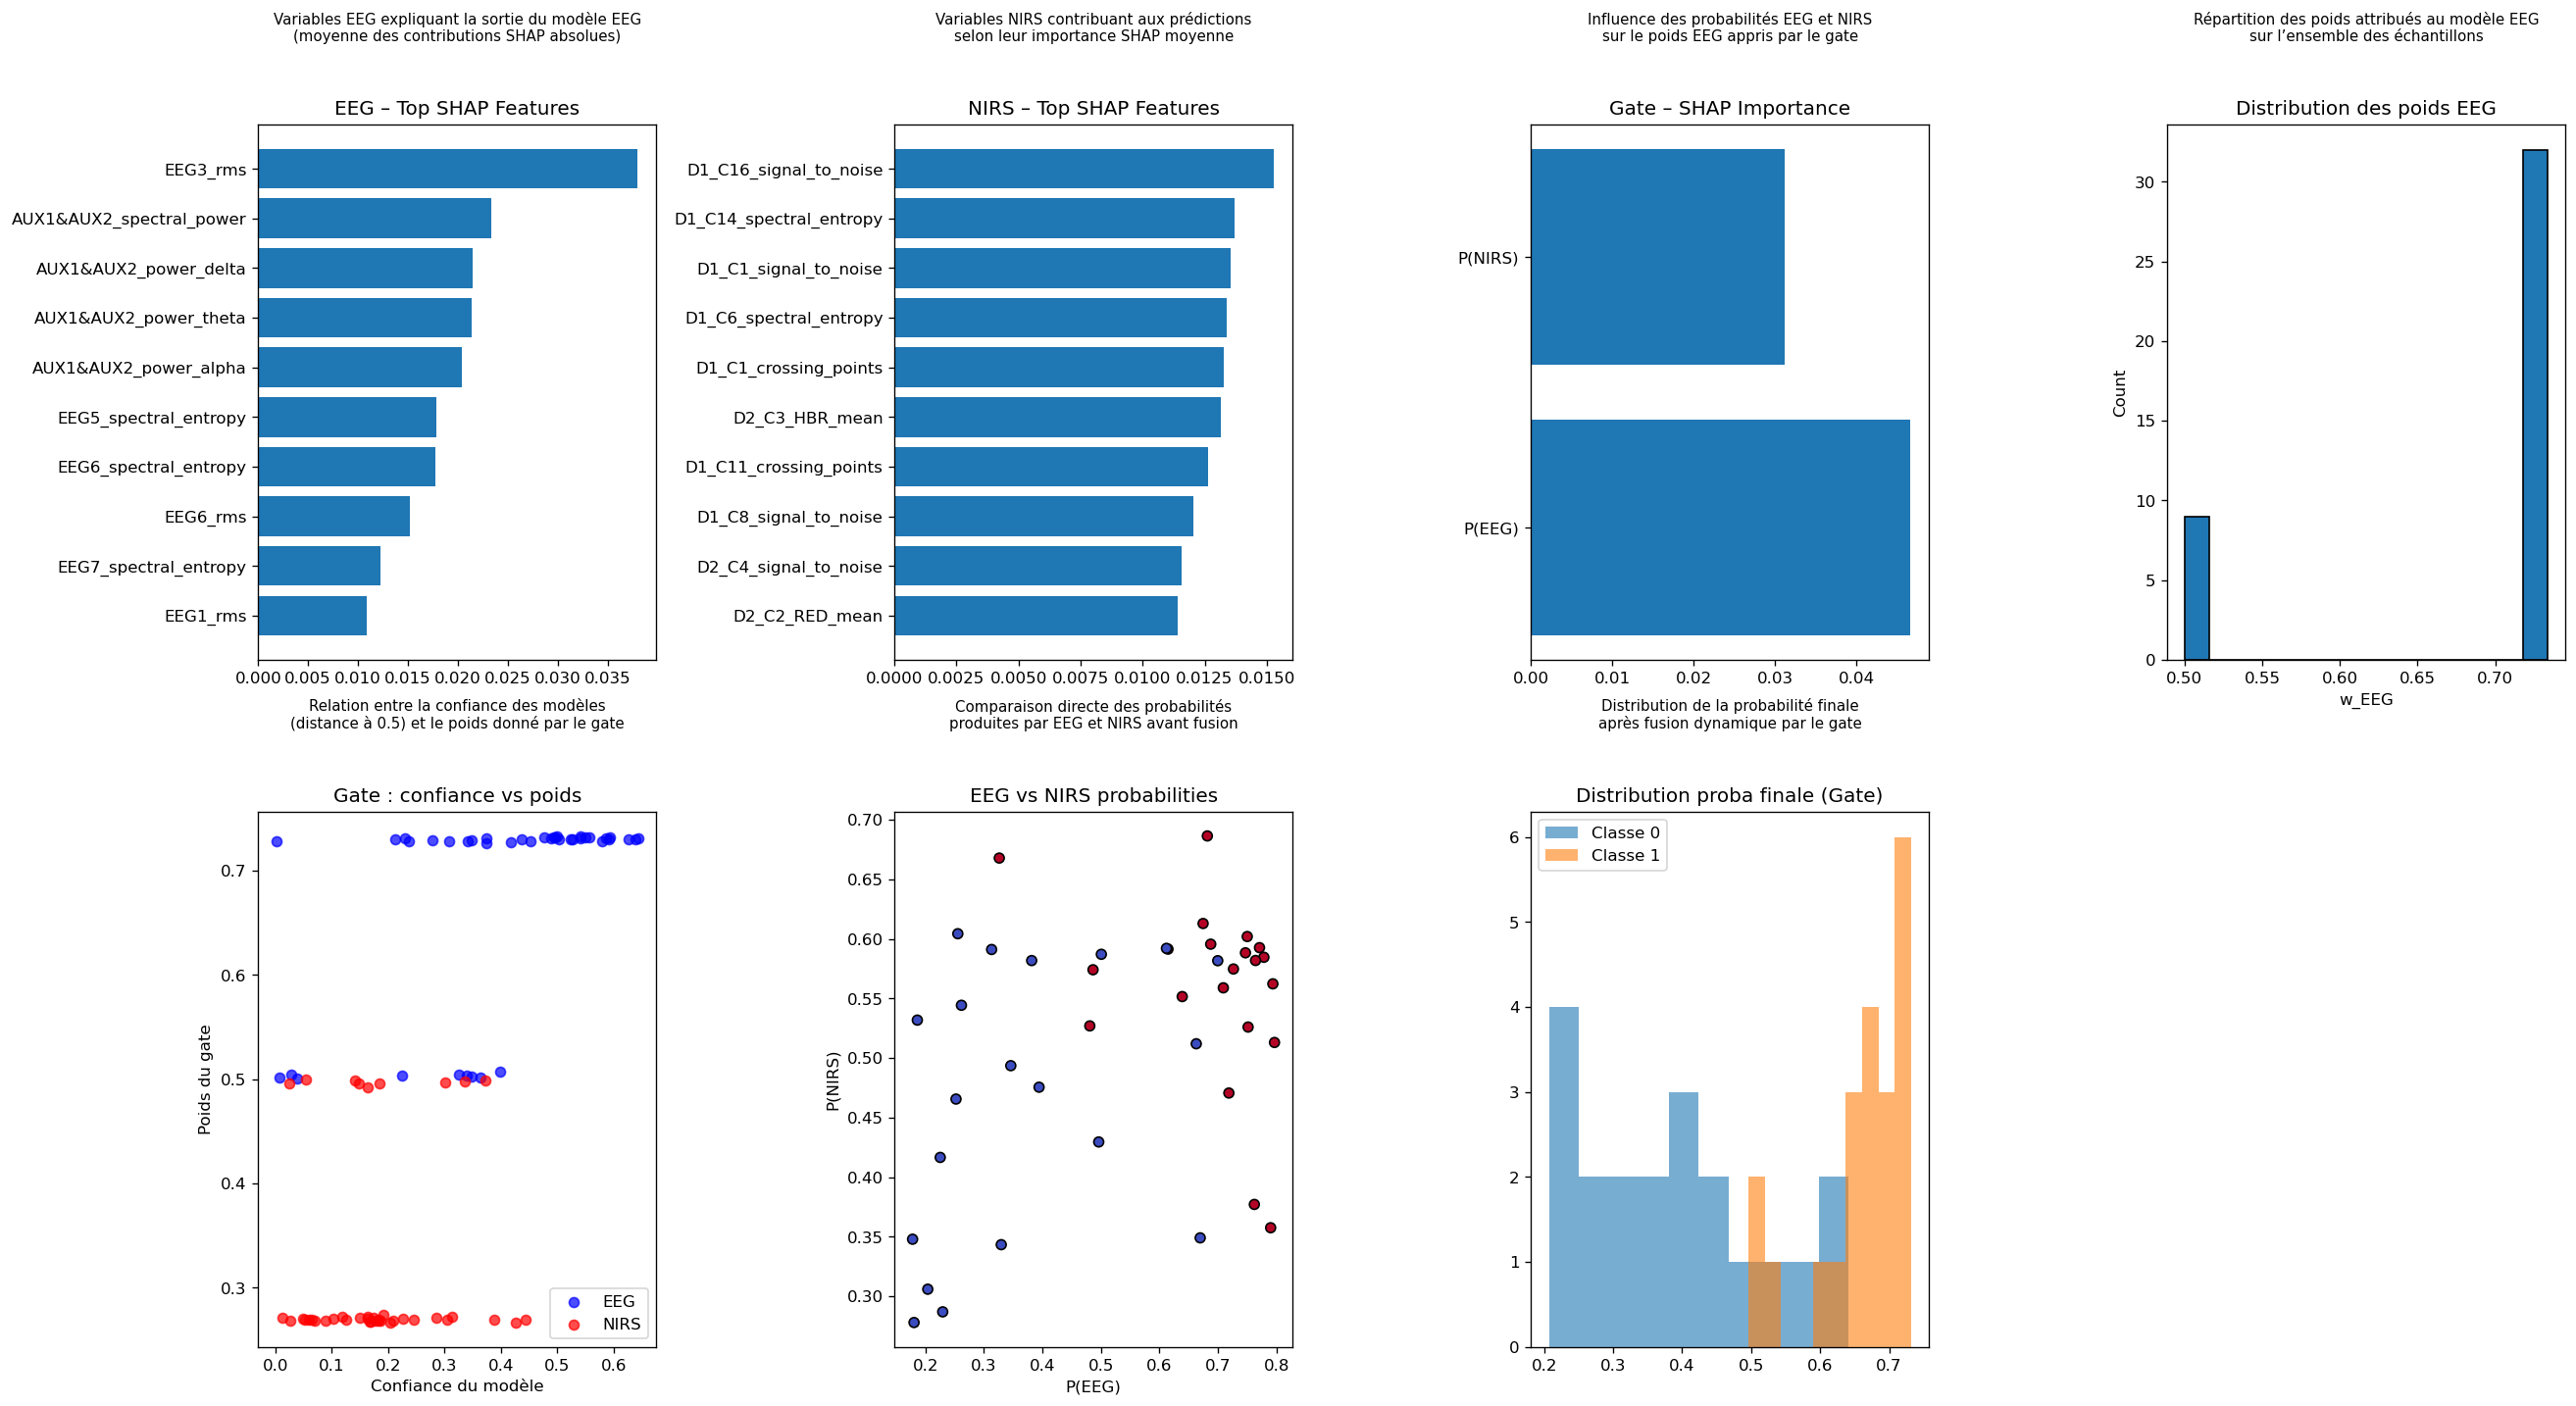


=== SANITY CHECK ===
Mean w_EEG   = 0.680
Mean w_NIRS  = 0.320
Mean P_EEG   = 0.532
Mean P_NIRS  = 0.513
Mean P_GATE  = 0.526


In [16]:
# ============================================================
# === SHAP ANALYSIS + VISUALISATIONS (POST GATING PIPELINE) ===
# ============================================================

import shap
import matplotlib.pyplot as plt
import numpy as np

# ============================================================
# 1) Refit FINAL models on ALL data
# ============================================================

best_eeg_pipe.fit(X_eeg, y)
best_nirs_pipe.fit(X_nirs, y)

eeg_cal_final  = calibrate_model(best_eeg_pipe,  X_eeg,  y, method="sigmoid")
nirs_cal_final = calibrate_model(best_nirs_pipe, X_nirs, y, method="sigmoid")

p_eeg_all  = eeg_cal_final.predict_proba(X_eeg)[:, 1]
p_nirs_all = nirs_cal_final.predict_proba(X_nirs)[:, 1]

# ============================================================
# 2) Entraînement FINAL du gate
# ============================================================

gate_final = build_and_fit_gate(p_eeg_all, p_nirs_all, y)

p_gate_all, w_eeg_all = fusion_gating_dynamic(
    p_eeg_all, p_nirs_all, gate_final
)
w_nirs_all = 1 - w_eeg_all

# ============================================================
# 3) Préparation SHAP EEG / NIRS
# ============================================================

eeg_scaler = best_eeg_pipe.named_steps["scaler"]
eeg_clf    = best_eeg_pipe.named_steps["clf"]
Xe_scaled  = eeg_scaler.transform(X_eeg)

def eeg_predict_proba_1(X):
    return eeg_clf.predict_proba(X)[:, 1]

nirs_scaler = best_nirs_pipe.named_steps["scaler"]
nirs_clf    = best_nirs_pipe.named_steps["clf"]
Xn_scaled   = nirs_scaler.transform(X_nirs)

def nirs_predict_proba_1(X):
    return nirs_clf.predict_proba(X)[:, 1]

n_bg = min(50, Xe_scaled.shape[0])
n_ex = min(25, Xe_scaled.shape[0])

Xe_bg, Xe_ex = Xe_scaled[:n_bg], Xe_scaled[:n_ex]
Xn_bg, Xn_ex = Xn_scaled[:n_bg], Xn_scaled[:n_ex]

# ============================================================
# 4) SHAP EEG
# ============================================================

eeg_explainer = shap.PermutationExplainer(eeg_predict_proba_1, Xe_bg)
eeg_shap = eeg_explainer(Xe_ex, max_evals=2 * Xe_ex.shape[1] + 1, silent=True)
eeg_shap_values = eeg_shap.values

# ============================================================
# 5) SHAP NIRS
# ============================================================

nirs_explainer = shap.PermutationExplainer(nirs_predict_proba_1, Xn_bg)
nirs_shap = nirs_explainer(Xn_ex, max_evals=2 * Xn_ex.shape[1] + 1, silent=True)
nirs_shap_values = nirs_shap.values

# ============================================================
# 6) SHAP DU GATE
# ============================================================

X_gate = np.column_stack([p_eeg_all, p_nirs_all])

def gate_predict_weight(X):
    _, w = fusion_gating_dynamic(X[:, 0], X[:, 1], gate_final)
    return w

gate_explainer = shap.PermutationExplainer(gate_predict_weight, X_gate[:n_bg])
gate_shap = gate_explainer(X_gate[:n_ex], max_evals=5, silent=True)
gate_shap_values = gate_shap.values

# ============================================================
# === VISUALISATIONS AVEC EXPLICATIONS VISIBLES ============
# ============================================================

plt.figure(figsize=(22, 12))

# ---------- (1) EEG SHAP ----------
ax = plt.subplot(2, 4, 1)
ax.text(0.5, 1.15,
        "Variables EEG expliquant la sortie du modèle EEG\n(moyenne des contributions SHAP absolues)",
        ha="center", va="bottom", transform=ax.transAxes, fontsize=9)
eeg_imp = np.abs(eeg_shap_values).mean(axis=0)
top_eeg = np.argsort(eeg_imp)[-10:]
plt.barh([X_eeg.columns[i] for i in top_eeg], eeg_imp[top_eeg])
plt.title("EEG – Top SHAP Features")

# ---------- (2) NIRS SHAP ----------
ax = plt.subplot(2, 4, 2)
ax.text(0.5, 1.15,
        "Variables NIRS contribuant aux prédictions\nselon leur importance SHAP moyenne",
        ha="center", va="bottom", transform=ax.transAxes, fontsize=9)
nirs_imp = np.abs(nirs_shap_values).mean(axis=0)
top_nirs = np.argsort(nirs_imp)[-10:]
plt.barh([X_nirs.columns[i] for i in top_nirs], nirs_imp[top_nirs])
plt.title("NIRS – Top SHAP Features")

# ---------- (3) Gate SHAP ----------
ax = plt.subplot(2, 4, 3)
ax.text(0.5, 1.15,
        "Influence des probabilités EEG et NIRS\nsur le poids EEG appris par le gate",
        ha="center", va="bottom", transform=ax.transAxes, fontsize=9)
gate_imp = np.abs(gate_shap_values).mean(axis=0)
plt.barh(["P(EEG)", "P(NIRS)"], gate_imp)
plt.title("Gate – SHAP Importance")

# ---------- (4) Distribution des poids ----------
ax = plt.subplot(2, 4, 4)
ax.text(0.5, 1.15,
        "Répartition des poids attribués au modèle EEG\nsur l’ensemble des échantillons",
        ha="center", va="bottom", transform=ax.transAxes, fontsize=9)
plt.hist(w_eeg_all, bins=15, edgecolor="black")
plt.xlabel("w_EEG")
plt.ylabel("Count")
plt.title("Distribution des poids EEG")

# ---------- (5) Confiance vs poids ----------
ax = plt.subplot(2, 4, 5)
ax.text(0.5, 1.15,
        "Relation entre la confiance des modèles\n(distance à 0.5) et le poids donné par le gate",
        ha="center", va="bottom", transform=ax.transAxes, fontsize=9)
conf_eeg  = np.abs(p_eeg_all  - 0.5) * 2
conf_nirs = np.abs(p_nirs_all - 0.5) * 2
plt.scatter(conf_eeg,  w_eeg_all,  label="EEG",  alpha=0.7, color="blue")
plt.scatter(conf_nirs, w_nirs_all, label="NIRS", alpha=0.7, color="red")
plt.xlabel("Confiance du modèle")
plt.ylabel("Poids du gate")
plt.legend()
plt.title("Gate : confiance vs poids")

# ---------- (6) EEG vs NIRS ----------
ax = plt.subplot(2, 4, 6)
ax.text(0.5, 1.15,
        "Comparaison directe des probabilités\nproduites par EEG et NIRS avant fusion",
        ha="center", va="bottom", transform=ax.transAxes, fontsize=9)
plt.scatter(p_eeg_all, p_nirs_all, c=y, cmap="coolwarm", edgecolor="k")
plt.xlabel("P(EEG)")
plt.ylabel("P(NIRS)")
plt.title("EEG vs NIRS probabilities")

# ---------- (7) Proba finale ----------
ax = plt.subplot(2, 4, 7)
ax.text(0.5, 1.15,
        "Distribution de la probabilité finale\naprès fusion dynamique par le gate",
        ha="center", va="bottom", transform=ax.transAxes, fontsize=9)
plt.hist(p_gate_all[y == 0], bins=10, alpha=0.6, label="Classe 0")
plt.hist(p_gate_all[y == 1], bins=10, alpha=0.6, label="Classe 1")
plt.legend()
plt.title("Distribution proba finale (Gate)")

plt.tight_layout()
plt.show()

# ============================================================
# === SANITY CHECK ==========================================
# ============================================================

print("\n=== SANITY CHECK ===")
print(f"Mean w_EEG   = {np.mean(w_eeg_all):.3f}")
print(f"Mean w_NIRS  = {np.mean(w_nirs_all):.3f}")
print(f"Mean P_EEG   = {np.mean(p_eeg_all):.3f}")
print(f"Mean P_NIRS  = {np.mean(p_nirs_all):.3f}")
print(f"Mean P_GATE  = {np.mean(p_gate_all):.3f}")
